# Network Analysis and Detecting Bid Rigging

This project attempts to demonstrate the use of graph theory tools in identifying possible cartel conduct among hypothetical players in a dummy procurement dataset. Data was randomly generated. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import matplotlib.colors as mcolors
from pyvis.network import Network
from read_data import load_data
import dynetworkx as dnx
df = load_data().set_index('DATE')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2020-01-01 to 2023-07-31
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PROJECT_ID      5000 non-null   int64  
 1   PROJECT_TYPE    5000 non-null   object 
 2   ABC             5000 non-null   float64
 3   NUM_BIDS        5000 non-null   int64  
 4   WINNER_NAME     5000 non-null   object 
 5   CONTRACT_PRICE  5000 non-null   float64
 6   DURATION        5000 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 312.5+ KB


In [3]:
df

,PROJECT_ID,PROJECT_TYPE,ABC,NUM_BIDS,WINNER_NAME,CONTRACT_PRICE,DURATION
DATE,,,,,,,
2020-01-01,3602,Infrastructure Projects,1.606239e+09,3,Denji,1.606233e+09,33
2020-01-01,3624,Goods,1.961096e+09,2,Power,1.961089e+09,11
2020-01-01,3642,Infrastructure Projects,1.980748e+08,2,Makima,1.980783e+08,13
2020-01-01,3804,Goods,1.265216e+09,1,Mikata,1.265216e+09,9
2020-01-01,3951,Consulting Services,5.962449e+08,2,Denji,5.962362e+08,4
...,...,...,...,...,...,...,...
2023-07-31,977,Infrastructure Projects,1.512355e+09,1,Reze,1.512346e+09,15
2023-07-31,2511,Goods,1.843869e+09,4,Power,1.843861e+09,12
2023-07-31,2640,Infrastructure Projects,4.920698e+08,8,Denji,4.920688e+08,18


For this dataset, let us assume that these players are competing for three types of projects for one particular government agency. 

In [4]:
# create win/loss column
df['WIN_LOSS'] = 1/df['NUM_BIDS']
df['DIFF_ABCtoBID'] = df['ABC'] - df['CONTRACT_PRICE']
df

,PROJECT_ID,PROJECT_TYPE,ABC,NUM_BIDS,WINNER_NAME,CONTRACT_PRICE,DURATION,WIN_LOSS,DIFF_ABCtoBID
DATE,,,,,,,,,
2020-01-01,3602,Infrastructure Projects,1.606239e+09,3,Denji,1.606233e+09,33,0.333333,6693.0
2020-01-01,3624,Goods,1.961096e+09,2,Power,1.961089e+09,11,0.500000,7022.0
2020-01-01,3642,Infrastructure Projects,1.980748e+08,2,Makima,1.980783e+08,13,0.500000,-3439.0
2020-01-01,3804,Goods,1.265216e+09,1,Mikata,1.265216e+09,9,1.000000,440.0
2020-01-01,3951,Consulting Services,5.962449e+08,2,Denji,5.962362e+08,4,0.500000,8715.0
...,...,...,...,...,...,...,...,...,...
2023-07-31,977,Infrastructure Projects,1.512355e+09,1,Reze,1.512346e+09,15,1.000000,8284.0
2023-07-31,2511,Goods,1.843869e+09,4,Power,1.843861e+09,12,0.250000,7711.0
2023-07-31,2640,Infrastructure Projects,4.920698e+08,8,Denji,4.920688e+08,18,0.125000,1045.0


In [5]:
# aggregate by month
df_monthly = df.groupby(
    [pd.Grouper(freq = 'M'), 'WINNER_NAME', 'PROJECT_TYPE']).agg(
        total_abc      = ('ABC', 'sum'),
        ave_abc        = ('ABC', 'mean'),
        total_bids     = ('NUM_BIDS', 'sum'),
        ave_bids       = ('NUM_BIDS', 'mean'),
        count_projects = ('PROJECT_ID','count'),
        total_cp       = ('CONTRACT_PRICE','sum'),
        ave_cp         = ('CONTRACT_PRICE','mean'),
        ave_win        = ('WIN_LOSS', 'mean'),
        ave_duration   = ('DURATION','mean'),
        ave_diff       = ('DIFF_ABCtoBID', 'mean')
        ).reset_index()


df_monthly

,DATE,WINNER_NAME,PROJECT_TYPE,total_abc,ave_abc,total_bids,ave_bids,count_projects,total_cp,ave_cp,ave_win,ave_duration,ave_diff
0,2020-01-31,Denji,Consulting Services,4.940888e+09,7.058411e+08,32,4.571429,7,4.940865e+09,7.058379e+08,0.322222,6.857143,3187.142857
1,2020-01-31,Denji,Goods,3.672017e+09,7.344034e+08,30,6.000000,5,3.672030e+09,7.344059e+08,0.193333,6.000000,-2481.000000
2,2020-01-31,Denji,Infrastructure Projects,1.089068e+10,1.555811e+09,25,3.571429,7,1.089065e+10,1.555807e+09,0.477551,28.857143,3786.714286
3,2020-01-31,Fami,Consulting Services,4.805469e+09,8.009116e+08,36,6.000000,6,4.805479e+09,8.009131e+08,0.211772,8.500000,-1529.000000
4,2020-01-31,Fami,Goods,2.138404e+09,7.128012e+08,10,3.333333,3,2.138396e+09,7.127985e+08,0.344444,6.333333,2721.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,2023-07-31,Power,Goods,8.042308e+09,1.005289e+09,36,4.500000,8,8.042298e+09,1.005287e+09,0.430556,6.750000,1236.125000
1197,2023-07-31,Power,Infrastructure Projects,7.474178e+08,7.474178e+08,10,10.000000,1,7.474175e+08,7.474175e+08,0.100000,30.000000,301.000000
1198,2023-07-31,Reze,Consulting Services,3.486021e+09,1.162007e+09,16,5.333333,3,3.486015e+09,1.162005e+09,0.188889,8.666667,2022.333333
1199,2023-07-31,Reze,Goods,2.441413e+09,1.220707e+09,11,5.500000,2,2.441421e+09,1.220711e+09,0.550000,6.000000,-3866.500000


In [6]:
#create subsets for the dataset by project type
df_infra = df[df['PROJECT_TYPE'] == 'Infrastructure Projects']
df_goods = df[df['PROJECT_TYPE'] == 'Goods']
df_const = df[df['PROJECT_TYPE'] == 'Consulting Services']

Let's focus on Infrastructure Projects for now. Why?

In [7]:
print(df_infra['WINNER_NAME'].value_counts())
print(df_goods['WINNER_NAME'].value_counts())
print(df_const['WINNER_NAME'].value_counts())


Makima       412
Denji        392
Mikata       375
Hayakawa      86
Nayuta        65
Reze          63
Power         56
Himeno        54
Pochita       51
Fami          51
Name: WINNER_NAME, dtype: int64
Hayakawa     192
Power        183
Mikata       183
Makima       178
Pochita      177
Fami         176
Denji        170
Himeno       162
Nayuta       159
Reze         149
Name: WINNER_NAME, dtype: int64
Hayakawa     197
Power        175
Denji        173
Reze         173
Makima       169
Himeno       168
Pochita      156
Nayuta       155
Mikata       154
Fami         146
Name: WINNER_NAME, dtype: int64


Here we can see that Makima, Denji and Mikata seem to have the lion's share of contracts won for infrastructure projects, while for the other types of projects, there seems to be no issue (though we can note that Hayakawa and Power have the same market position for both types of projects)

### What to do next when faced with this dataset?

In [8]:
df_monthly_infra = df_monthly[df_monthly['PROJECT_TYPE']=='Infrastructure Projects']
df_monthly_infra

,DATE,WINNER_NAME,PROJECT_TYPE,total_abc,ave_abc,total_bids,ave_bids,count_projects,total_cp,ave_cp,ave_win,ave_duration,ave_diff
2,2020-01-31,Denji,Infrastructure Projects,1.089068e+10,1.555811e+09,25,3.571429,7,1.089065e+10,1.555807e+09,0.477551,28.857143,3786.714286
5,2020-01-31,Fami,Infrastructure Projects,3.146749e+09,1.573375e+09,11,5.500000,2,3.146752e+09,1.573376e+09,0.305556,22.000000,-1534.500000
8,2020-01-31,Hayakawa,Infrastructure Projects,1.967312e+09,9.836561e+08,4,2.000000,2,1.967310e+09,9.836548e+08,0.666667,22.000000,1326.000000
11,2020-01-31,Himeno,Infrastructure Projects,9.876383e+08,9.876383e+08,10,10.000000,1,9.876372e+08,9.876372e+08,0.100000,32.000000,1058.000000
14,2020-01-31,Makima,Infrastructure Projects,4.908808e+09,7.012583e+08,34,4.857143,7,4.908799e+09,7.012570e+08,0.286508,20.285714,1284.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,2023-07-31,Mikata,Infrastructure Projects,8.450106e+09,1.056263e+09,37,4.625000,8,8.450112e+09,1.056264e+09,0.304514,25.125000,-736.125000
1191,2023-07-31,Nayuta,Infrastructure Projects,1.153905e+09,1.153905e+09,3,3.000000,1,1.153898e+09,1.153898e+09,0.333333,14.000000,6667.000000
1194,2023-07-31,Pochita,Infrastructure Projects,1.515299e+09,1.515299e+09,3,3.000000,1,1.515299e+09,1.515299e+09,0.333333,27.000000,579.000000
1197,2023-07-31,Power,Infrastructure Projects,7.474178e+08,7.474178e+08,10,10.000000,1,7.474175e+08,7.474175e+08,0.100000,30.000000,301.000000


We first have to construct our adjacency matrix based on what we are interested in understanding.

1. We understand that infrastructure projects seem to be concentrated around a few (only 3) players in the market.
2. We also understand that Consulting Services and Goods seem to be less concentrated based on the frequency distribution of bids
3. We would like to understand whether the other players can effectively compete on the same bids.
4. Ultimately, we want to understand whether the bidders are related in some way. Some key stylized observations:

    a. Do the same players compete on a monthly basis?
    
    b. Does the number of players evolve over time?
    
    c. Can we find some degree of coordination among bidders based on the number of projects that they participated in the past few months?
    
    d. Do they divide the market based on the duration of the contracts?
    
    e. Did the difference between the contract price and ABC vary across time?

As you can see, there are a multitude of reasons as to why we can gather interesting findings from such a dataset. 

For now, let us focus on item 4a and figure out if the same players compete on a monthly basis. Let's also focus on infrastructure projects for this exercise.



In [9]:
# let's look at infrastructure projects and figure out who are the common winners per month

# for January 2020 - 2023
print(df_monthly_infra[df_monthly_infra['DATE']== "2020-01-31"].loc[:,['WINNER_NAME', 'count_projects', 'ave_win','total_cp', 'ave_diff']].sort_values(by = 'total_cp',ascending = False))
print(df_monthly_infra[df_monthly_infra['DATE']== "2021-01-31"].loc[:,['WINNER_NAME', 'count_projects', 'ave_win','total_cp',  'ave_diff']].sort_values(by = 'total_cp',ascending = False))
print(df_monthly_infra[df_monthly_infra['DATE']== "2022-01-31"].loc[:,['WINNER_NAME', 'count_projects', 'ave_win','total_cp',  'ave_diff']].sort_values(by = 'total_cp',ascending = False))
print(df_monthly_infra[df_monthly_infra['DATE']== "2023-01-31"].loc[:,['WINNER_NAME', 'count_projects', 'ave_win','total_cp',  'ave_diff']].sort_values(by = 'total_cp',ascending = False))

   WINNER_NAME  count_projects   ave_win      total_cp     ave_diff
2        Denji               7  0.477551  1.089065e+10  3786.714286
14      Makima               7  0.286508  4.908799e+09  1284.428571
17      Mikata               8  0.382639  3.708642e+09 -4904.875000
23     Pochita               2  0.312500  3.387701e+09 -7267.000000
26       Power               2  0.600000  3.188062e+09 -2963.500000
5         Fami               2  0.305556  3.146752e+09 -1534.500000
8    Hayakawa                2  0.666667  1.967310e+09  1326.000000
11      Himeno               1  0.100000  9.876372e+08  1058.000000
20      Nayuta               1  1.000000  3.050298e+08  2832.000000
    WINNER_NAME  count_projects   ave_win      total_cp     ave_diff
335       Denji              16  0.319965  1.913199e+10  2007.750000
345      Makima              11  0.441270  1.182999e+10  1663.181818
348      Mikata              13  0.342613  1.022360e+10 -2200.384615
340   Hayakawa                2  0.562500  2

In [10]:
# let's create a bipartite graph then measure its features
df_monthly
df_jan2020 = df_monthly[df_monthly['DATE'] == '2020-01-31']
df_jan2020

,DATE,WINNER_NAME,PROJECT_TYPE,total_abc,ave_abc,total_bids,ave_bids,count_projects,total_cp,ave_cp,ave_win,ave_duration,ave_diff
0,2020-01-31,Denji,Consulting Services,4.940888e+09,7.058411e+08,32,4.571429,7,4.940865e+09,7.058379e+08,0.322222,6.857143,3187.142857
1,2020-01-31,Denji,Goods,3.672017e+09,7.344034e+08,30,6.000000,5,3.672030e+09,7.344059e+08,0.193333,6.000000,-2481.000000
2,2020-01-31,Denji,Infrastructure Projects,1.089068e+10,1.555811e+09,25,3.571429,7,1.089065e+10,1.555807e+09,0.477551,28.857143,3786.714286
3,2020-01-31,Fami,Consulting Services,4.805469e+09,8.009116e+08,36,6.000000,6,4.805479e+09,8.009131e+08,0.211772,8.500000,-1529.000000
4,2020-01-31,Fami,Goods,2.138404e+09,7.128012e+08,10,3.333333,3,2.138396e+09,7.127985e+08,0.344444,6.333333,2721.333333
5,2020-01-31,Fami,Infrastructure Projects,3.146749e+09,1.573375e+09,11,5.500000,2,3.146752e+09,1.573376e+09,0.305556,22.000000,-1534.500000
6,2020-01-31,Hayakawa,Consulting Services,2.083826e+09,1.041913e+09,12,6.000000,2,2.083825e+09,1.041912e+09,0.222222,9.000000,435.500000
7,2020-01-31,Hayakawa,Goods,4.021869e+09,1.005467e+09,13,3.250000,4,4.021887e+09,1.005472e+09,0.341667,8.000000,-4426.000000
8,2020-01-31,Hayakawa,Infrastructure Projects,1.967312e+09,9.836561e+08,4,2.000000,2,1.967310e+09,9.836548e+08,0.666667,22.000000,1326.000000
9,2020-01-31,Himeno,Consulting Services,5.830111e+09,1.166022e+09,30,6.000000,5,5.830107e+09,1.166021e+09,0.270794,7.400000,743.200000


[('Consulting Services', 'Denji', {'weight': 7}), ('Consulting Services', 'Fami', {'weight': 6}), ('Consulting Services', 'Hayakawa ', {'weight': 2}), ('Consulting Services', 'Himeno', {'weight': 5}), ('Consulting Services', 'Makima', {'weight': 3}), ('Consulting Services', 'Mikata', {'weight': 5}), ('Consulting Services', 'Nayuta', {'weight': 1}), ('Consulting Services', 'Pochita', {'weight': 5}), ('Consulting Services', 'Power', {'weight': 2}), ('Consulting Services', 'Reze', {'weight': 8}), ('Goods', 'Denji', {'weight': 5}), ('Goods', 'Fami', {'weight': 3}), ('Goods', 'Hayakawa ', {'weight': 4}), ('Goods', 'Himeno', {'weight': 1}), ('Goods', 'Makima', {'weight': 3}), ('Goods', 'Mikata', {'weight': 7}), ('Goods', 'Nayuta', {'weight': 5}), ('Goods', 'Pochita', {'weight': 4}), ('Goods', 'Power', {'weight': 4}), ('Goods', 'Reze', {'weight': 2}), ('Infrastructure Projects', 'Denji', {'weight': 7}), ('Infrastructure Projects', 'Fami', {'weight': 2}), ('Infrastructure Projects', 'Hayakawa 

{'Consulting Services': Text(1, 27.25, 'Consulting Services'),
 'Goods': Text(1, 28.25, 'Goods'),
 'Infrastructure Projects': Text(1, 26.25, 'Infrastructure Projects'),
 'Denji': Text(0, 2.25, 'Denji'),
 'Fami': Text(0, 5.25, 'Fami'),
 'Hayakawa ': Text(0, 8.25, 'Hayakawa '),
 'Himeno': Text(0, 11.25, 'Himeno'),
 'Makima': Text(0, 14.25, 'Makima'),
 'Mikata': Text(0, 17.25, 'Mikata'),
 'Nayuta': Text(0, 20.25, 'Nayuta'),
 'Pochita': Text(0, 23.25, 'Pochita'),
 'Power': Text(0, 26.25, 'Power'),
 'Reze': Text(0, 28.25, 'Reze')}

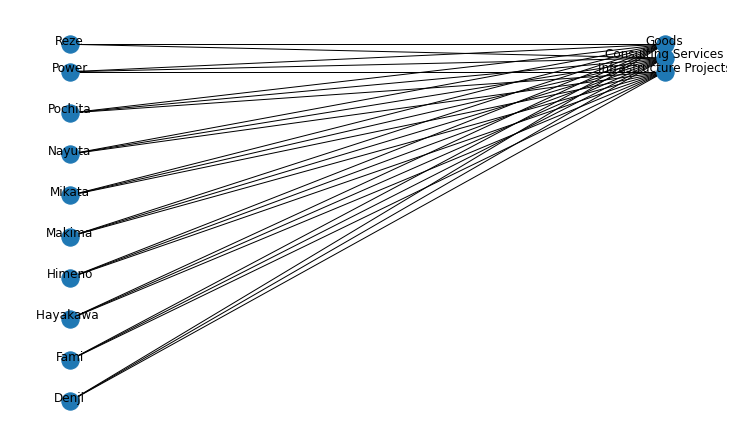

In [11]:
# create graph
B = nx.Graph()
B.add_nodes_from(df_jan2020['PROJECT_TYPE'], bipartite = 0)
B.add_nodes_from(df_jan2020['WINNER_NAME'], bipartite = 1)
B.add_weighted_edges_from(
    [(row['WINNER_NAME'], row['PROJECT_TYPE'], row['count_projects']) for idx, row in df_jan2020.iterrows()],weight ='weight'
)
print(B.edges(data=True))
pos = {node:[0, i] for i,node in enumerate(df_jan2020['WINNER_NAME'])}
pos.update({node:[1, i] for i,node in enumerate(df_jan2020['PROJECT_TYPE'])})
plt.figure(figsize=(10,6))
nx.draw(B, pos, with_labels=False)
for p in pos:  # raise text positions
    pos[p][1] += 0.25
nx.draw_networkx_labels(B, pos)

In [12]:
A = nx.adjacency_matrix(B)
print(A.todense())
#print(nx.betweenness_centrality(B))
print(nx.bipartite.maximum_matching(B))

[[0 0 0 7 6 2 5 3 5 1 5 2 8]
 [0 0 0 5 3 4 1 3 7 5 4 4 2]
 [0 0 0 7 2 2 1 7 8 1 2 2 0]
 [7 5 7 0 0 0 0 0 0 0 0 0 0]
 [6 3 2 0 0 0 0 0 0 0 0 0 0]
 [2 4 2 0 0 0 0 0 0 0 0 0 0]
 [5 1 1 0 0 0 0 0 0 0 0 0 0]
 [3 3 7 0 0 0 0 0 0 0 0 0 0]
 [5 7 8 0 0 0 0 0 0 0 0 0 0]
 [1 5 1 0 0 0 0 0 0 0 0 0 0]
 [5 4 2 0 0 0 0 0 0 0 0 0 0]
 [2 4 2 0 0 0 0 0 0 0 0 0 0]
 [8 2 0 0 0 0 0 0 0 0 0 0 0]]
{'Infrastructure Projects': 'Denji', 'Consulting Services': 'Fami', 'Goods': 'Hayakawa ', 'Denji': 'Infrastructure Projects', 'Fami': 'Consulting Services', 'Hayakawa ': 'Goods'}


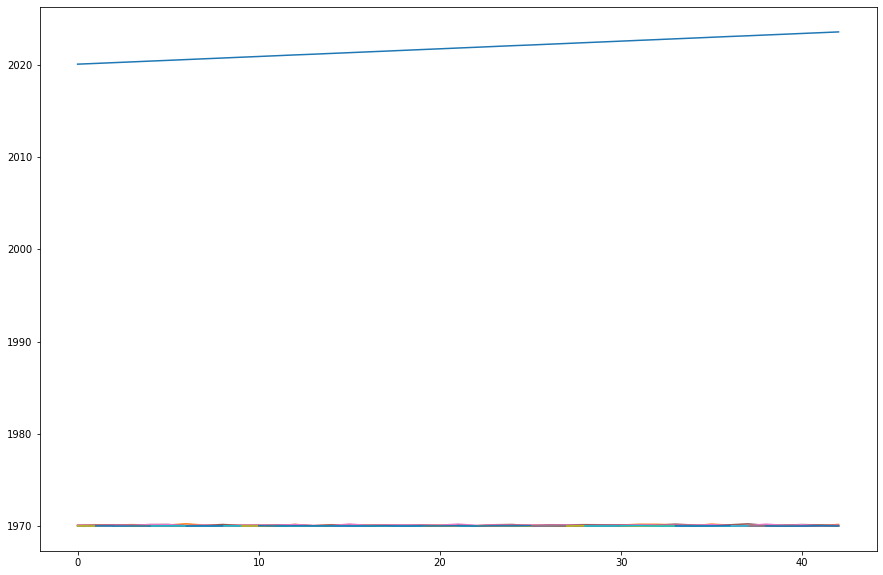

In [13]:
# let's plot this first and see which relationships we can compare
fig = plt.figure(figsize=(15,10))
df_monthly_infra_wide = df_monthly_infra.loc[:,['DATE', 'WINNER_NAME', 'total_bids']].pivot(index = 'DATE', columns = 'WINNER_NAME')
df_monthly_infra_wide.columns = df_monthly_infra_wide.columns.get_level_values(1)
df_monthly_infra_wide=df_monthly_infra_wide.reset_index()
for i in df_monthly_infra_wide:
    plt.plot(df_monthly_infra_wide.index, df_monthly_infra_wide[i])    
#df_monthly_infra_wide

In [14]:
df_monthly_infra[df_monthly_infra['DATE']< "2020-02-01"]

,DATE,WINNER_NAME,PROJECT_TYPE,total_abc,ave_abc,total_bids,ave_bids,count_projects,total_cp,ave_cp,ave_win,ave_duration,ave_diff
2,2020-01-31,Denji,Infrastructure Projects,1.089068e+10,1.555811e+09,25,3.571429,7,1.089065e+10,1.555807e+09,0.477551,28.857143,3786.714286
5,2020-01-31,Fami,Infrastructure Projects,3.146749e+09,1.573375e+09,11,5.500000,2,3.146752e+09,1.573376e+09,0.305556,22.000000,-1534.500000
8,2020-01-31,Hayakawa,Infrastructure Projects,1.967312e+09,9.836561e+08,4,2.000000,2,1.967310e+09,9.836548e+08,0.666667,22.000000,1326.000000
11,2020-01-31,Himeno,Infrastructure Projects,9.876383e+08,9.876383e+08,10,10.000000,1,9.876372e+08,9.876372e+08,0.100000,32.000000,1058.000000
14,2020-01-31,Makima,Infrastructure Projects,4.908808e+09,7.012583e+08,34,4.857143,7,4.908799e+09,7.012570e+08,0.286508,20.285714,1284.428571
17,2020-01-31,Mikata,Infrastructure Projects,3.708603e+09,4.635754e+08,37,4.625000,8,3.708642e+09,4.635803e+08,0.382639,22.500000,-4904.875000
20,2020-01-31,Nayuta,Infrastructure Projects,3.050326e+08,3.050326e+08,1,1.000000,1,3.050298e+08,3.050298e+08,1.000000,15.000000,2832.000000
23,2020-01-31,Pochita,Infrastructure Projects,3.387686e+09,1.693843e+09,10,5.000000,2,3.387701e+09,1.693850e+09,0.312500,23.000000,-7267.000000
26,2020-01-31,Power,Infrastructure Projects,3.188056e+09,1.594028e+09,6,3.000000,2,3.188062e+09,1.594031e+09,0.600000,24.000000,-2963.500000
